# Machine Learning Workshop: Causal Effect

## Case Study:
The Lalonde data set (LaLonde, 1986; Dehejia and Wahba, 1999, 2002) is a classic in causal inference.
In this data set, treatment refers to enrollment in a labour training program (the National Supported Work Demonstration) and control to not enrollment in the program.
The goal is to evaluate the effect of the labour training program on the earnings of disadvantaged workers.

The data set contains 445 observations, corresponding to 185 treated and 260 control workers, and ten variables. 
The treatment assignment indicator is the first variable of the data frame: treatment (1 = treated; 0 = control). 
The next seven variables are the covariates.
The last variable is the outcome, earnings after the labour training program.

#### The Data
Lalonde dataset is dataset used by Dehejia and Wahba (1999) to evaluate propensity score matching.

#### Data description
A data frame with 445 observations on the following 10 variables.

* **age** :age in years.
* **educ**: years of schooling.
* **black**: indicator variable for blacks.
* **hisp**: indicator variable for Hispanics.
* **married**: indicator variable for martial status.
* **nodegr**: indicator variable for high school diploma.
* **re74**: real earnings in 1974.
* **re75**: real earnings in 1975.
* **re78**: real earnings in 1978.
* **treat**: an indicator variable for treatment status.

# Problem Statement

**Notations.**
* Y represents the *response*, here is is 1978 earnings ('re78')
* D represents the *treatment*: the job training program ('treat')
* X represents the *confounding variables*, here it likely is age, education, race and marital status. X is also called a *covariate* or the *counter factual*.

**Aims.**

Find the average treatment effect in the treatment group (ATT) on RE78.

The Average Treatment Effect (**ATE**):
$$\Delta = E[Y_{1} - Y_{0}]$$

However, as we saw, if we try to estimate this quantity from the row observational distribution, we get:
$$\Delta_{raw} = E[Y|D=1] - E[Y|D=0] = E[Y_{1}|D=1] - E[Y_{0}|D=0] \\
\neq \Delta = E[Y_{1} - Y_{0}]$$

because: 
$$E[Y_{i}|D=i] \neq E[Y_{i}]$$

**General problem.** If we believe that age, education, race, and marital status all have a likely influence on earnings Y, we need a way to disentangle the effect of D on Y from the perturbative effect of X on Y.

Indeed we saw that the treatment assignment is probably not independent of each subject's potential outcomes, e.g. poorer people are more represented in the treatment group than in the control group.

However the treatment is assumed to be *unconfounded* in the sense that the dependence between the treatment assignment and the outcomes is *only through* something we observe, namely the covariates X.

What this means is that if we control for X, i.e. look across people with similar levels of X, then the difference between treated and control should be attributable to the treatment itself, just as a randomized experiment would be.

This is the assumption, and if it doesn't hold our results could be completely wrong.

## Exploratory Data Analysis
Let first do an exploration of causal inference in python using the famous Lalonde dataset.

* Causal inference is a technique to estimate the effect of one variable onto another, given the presence of other influencing variables (confonding factors) that we try to keep 'controlled'.

The study looked at the effectiveness of a job training program (the treatment) on the real earnings of an individual, a couple years after completion of the program.

### Packages

In [1]:
# Core
import numpy as np
import scipy
import causalinference
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

In [2]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

### 1. Overview of Dataset

Let's take a quick look at our data. This section aims to give a general ideas of the covariates in our dataset.

In [3]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [4]:
# let's have an overview of the data
lalonde_df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


**Here is the raw difference in earning between the control group and the treated group:**



In [5]:
lalonde_df.groupby('treat')['re78'].agg(['median','mean'])

,median,mean
treat,,
0,4975.505,6984.169742
1,4232.309,6349.143530


#### Question 1
The control group has higher earning that the treatment group - does this mean the treatment had a negative impact?

#### Answer Q1
Take a look at the plot of the different income distributions:

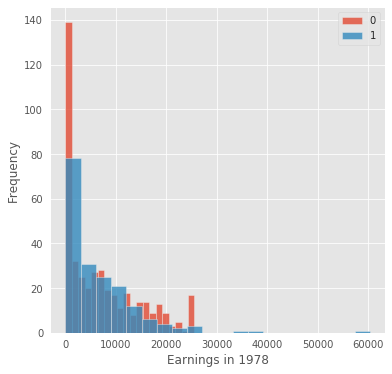

In [6]:
# plot income distribution for 1978
ax, _ = lalonde_df.groupby('treat')['re78'].plot(kind='hist', 
                                         bins=20, alpha=0.8, legend=True,
                                         figsize=(6,6))
ax.set_xlabel("Earnings in 1978");

This dataset is not a **balanced trial**. Indeed people in the control group are very different from people in the test (treatment) group. We can also try to look for plot distribution for different covariate:

* **age** - age in years.
* **educ** - years of schooling.
* **re74** - real earnings in 1974.
* etc.

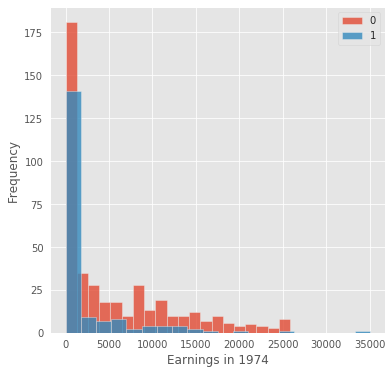

In [7]:
# plot income distribution for 1974
ax, _ = lalonde_df.groupby('treat')['re74'].plot(kind='hist', 
                                              bins=20, alpha=0.8, legend=True,
                                              figsize=(6,6))
ax.set_xlabel("Earnings in 1974");        # set title for y axis

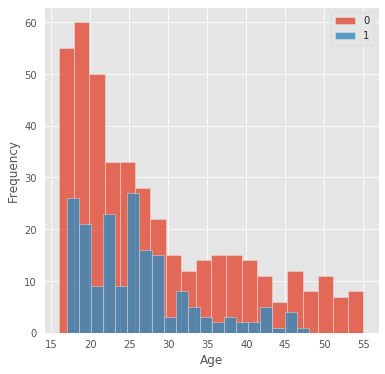

In [8]:
# plot age distribution
ax, _ = lalonde_df.groupby('treat')['age'].plot(kind='hist',
                                     bins=20, alpha=0.8, legend=True,
                                     figsize=(6,6))
ax.set_xlabel("Age");        # set title for y axis

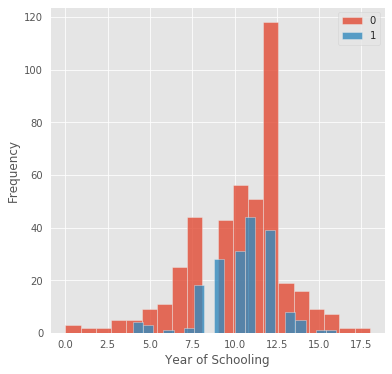

In [9]:
# plot education distribution
ax, _ = lalonde_df.groupby('treat')['educ'].plot(kind='hist',
                                     bins=20, alpha=0.8, legend=True,
                                     figsize=(6,6))
ax.set_xlabel("Year of Schooling");        # set title for y axis

#### Setups dataframe

Before we start our exploration on causality effect in our dataset, let's perform some simple setup.

* we seperate `treat` (treatment) indicator from our dataset. We will want to use this as a target for fitting later
* we are interested in knowing the treatment effect on `re78` (revenue/earnings in 1978)

In [10]:
# create seperate structure for data and target 
treatment = lalonde_df['treat']
rev78 = lalonde_df['re78']
cleaned_df = lalonde_df.drop(['treat', 're78'], axis=1)

### 2. Assess Balance

Given all of these covariates and our column treatment that indicates whether the subject received the treatment or control, we wish to have a quantitative way of measuring whether our covariates are balanced between the two groups.

To assess whether balance has been achieved, we can look at standardized mean differences (smd), which is calculated by the difference in the means between the two groups divided by the pooled standard deviation.

$$SMD(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}},$$
 
Where:

* $(\bar{x}_{t}$, $\bar{x}_{c}$) denotes the mean of that feature for the treatment and control group respectively. Note that people often times report the absolute value of this number.
* ($s^{2}_{t}$, $s^{2}_{c}$)  denotes the standard deviation of that feature for the treatment and control group respectively. For the denominator we're essentially calculating the pooled standard deviation.
We can calculate the standardized mean differences for every feature. If our calculated smd is 1, then that means there's a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that are commonly used to determine whether that feature is balanced or not, (similar to the 0.05 for p-value idea).

* Smaller than  0.1 . For a randomized trial, the smd between all of the covariates should typically fall into this bucket.
* 0.1  -  0.2 . Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose smd fall under this range.
* 0.2 . Values that are greater than this threshold are considered seriously imbalanced.

#### Question 2. 

Assess covariate balance across the treatment groups.
For this, compute the absolute standardized differences in means in the covariates.

Remember that when ASMDs greater than 0.2 are often considered as substantial covariate imbalances (Rosenbaum and Rubin, 1985).
Comment on covariate balance.
What is wrong with taking a simple (unadjusted) difference in means in the outcomes to estimate the average effect of treatment?

#### Answer Q2

Below is how we compute the ASMD (Absolute Standard Mean Difference).

* We group our calculated SMD in *tableone* based on the *treatment* indicator. The resulting grouped table is usually called *table one* in the study of causality effect.  
* We create a helper function that computes Absolute SMD from *table one*

In [11]:
# Define params and inputs
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
agg_operations = {'treat': 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in covariates
})

In [12]:
def compute_table_one_smd(table_one, covariates, round_digits=4):
    feature_smds = []
    for feature in covariates:
        feature_table_one = table_one[feature].values
        neg_mean = feature_table_one[0, 0]
        neg_std = feature_table_one[0, 1]
        pos_mean = feature_table_one[1, 0]
        pos_std = feature_table_one[1, 1]

        smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
        smd = round(abs(smd), round_digits)
        feature_smds.append(smd)

    return pd.DataFrame({'covariates': covariates, 'smd': feature_smds})

In [13]:
table_one_matched = lalonde_df.groupby('treat').agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched, covariates)
table_one_smd_matched

,covariates,smd
0,age,0.2419
1,educ,0.0448
2,black,1.6677
3,hispan,0.2769
4,married,0.7195
5,nodegree,0.2350
6,re74,0.5958
7,re75,0.2870


We can observed from the ASMD table that several covariates suffer from imbalance. Recall our rule of thumb: 
* Smaller than 0.1 . For a randomized trial, the smd between all of the covariates should typically fall into this bucket.
* 0.1  -  0.2 . Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose smd fall under this range.
* Bigger than 0.2 . Values that are greater than this threshold are considered seriously imbalanced.

We see that *age*, *hispan*, *married*, *nodegree*, *re74* and *re75* covariates are those that are considered seriously imbalanced.

**Effect of Imbalance:** In addition to that, we can also calculate the raw difference. Take a look on how imbalance might affect our conclusion of how the treatment, job training program, affect the employee earnings

In [14]:
# we seperate the dataframe based on it's 
# corresponding true label value
mask = lalonde_df['treat'] == 1
lalonde_treat = lalonde_df[mask]
lalonde_notreat = lalonde_df[~mask]

print('treatment count:', lalonde_treat.shape)
print('control count:', lalonde_notreat.shape)

treatment count: (185, 10)
control count: (429, 10)


In [15]:
rev_treated_mean = lalonde_treat['re78'].mean()
rev_notreat_mean = lalonde_notreat['re78'].mean()

print("The raw difference: ", rev_treated_mean - rev_notreat_mean)

The raw difference:  -635.0262120374209


Surprisingly, the treated group (trained) is earning *$635* less than the control group. Could this be true? If we apply raw difference without taking account for the imbalanced, we might come to a false conclusion.

### 3. Simple ATE Fitting with Regression

#### Question 3.
Estimate the average effect by using OLS regression and explaining the outcome `re78` on the treatment indicator and all the other covariates.  Comment on the robustness/validity of this procedure.

Let's look at how we can model our dataset using the simplest type of model we can use is a linear model (OLS of degree 1):

$$Y_0 = \alpha + \beta X + \epsilon$$
$$Y_1 = Y_0 + \gamma D $$

If this is accurate, fitting the following model to the data using linear regression will give us an estimate of the Average Treatment Effect (ATE):
$$Y = \alpha + \beta X + \gamma D$$

$\epsilon$ is called a residual and represents the noise

#### Answer Q3

In [16]:
formula = 're78 ~ treat + age + educ + black + hispan + married + nodegree + re74 + re75'
logit_model = smf.ols(formula=formula, data=lalonde_df).fit()

print(logit_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     11.64
Date:                Sat, 02 Nov 2019   Prob (F-statistic):           5.99e-17
Time:                        12:28:50   Log-Likelihood:                -6297.8
No. Observations:                 614   AIC:                         1.262e+04
Df Residuals:                     604   BIC:                         1.266e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.5145   2436.746      0.027      0.9

#### Result Interpretation:

Take a look at the coefficient for `treat` (treament). This is the estimates for the treatment effect on the earnings in 1978 to the subject of treatment.

**This model predicts that the Average Treatment Effect (ATE, the job training)** is *$1548* extra annual earnings. This is very different from our previous raw results predicting that the job training had negative effects on earnings!**

Assuming that our model accurately describes the counterfactual X, CausalModel provides the 95% confidence interval. What this means is that, if we were to repeat this treatment experiment, in 95% of the cases the Average Treatment Effect would be within that interval. That doesn't mean that the true value is within that interval.


Based on the assumption that the residuals are normally distributed, the 95% confidence interval is calculated as:
$$ AVG \pm 1.96 * STD  / \sqrt{n}$$

In practice, as the confidence interval is very large, my interpretation is that the experiment should have had more people if a better estimate of the extra earnings was desired. Ways to control the standard deviation could also be explored. 

Overall, assuming that we controlled for all the effects and did it well, it seems that the job training had a positive effect on earnings. Indeed, although the standard deviation is very large, the p value of 0.035 rejects the null hypothesis (no effect) with a confidence level of 97.5%. However, the truth is that we don't know if we modelled the counterfactual well, and this could change everything... As we will see later, estimators such as the Ordinary Least Square (OLS) estimator can behave poorly when there is not enough covariate overlap, and that's because the estimator needs to extrapolate too much from one group to another.

**Improvement -** A more structured approach as we will see later can allow us to increase our confidence that the covariants are well controlled for. We will see many steps, but one simple idea is the technique of matching: the idea is to find for each sample which received the treatment a *similar* sample in the control group, and to directly compare these values.

### 4. Propensity Score

**Propensity Score** - the probability of receiving the treatment, conditional on the covariates.


We've stated during the matching procedure, each test group member is paired with a similar member of the control group. Here we'll elaborate on what we mean by "*similar*". Similarity is often times computed using propensity scores, which is defined as the probability of receiving treatment, rather than control, given covariates $ X$ .

We'll define  $A=1$ for treatment and  $A=0$  for control. The propensity score for subject  $i$  is denoted as  πi .

$$\pi_i=P(A=1|X_i)$$
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they'll receive the treatment. We can calculate this score by fitting our favorite classification algorithm to our data (input features are our covariates, and the labels are whether that person belongs to the treatment or control group).

With these knowledge in mind, let's get our hands dirty with some code, we'll discuss more as we go along.

#### Question 4.

**Task -** Now, estimate the **propensity score** using regression/classifier. 

As mentioned above, the propensity score itself is the probability of receiving treatment given the covariates.
We can estimate the probability by fitting the data to a classifier and let it output probability scores of having treatment corresponding to each data point. 

In [17]:
# drop labeling (e.g NSW3) from the targets data
targets = treatment.reset_index().drop('index', axis=1);
X = cleaned_df.reset_index().drop('index', axis=1);

#### 1. Logistic Regression
Logistic Regression Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. It can be used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick.

In [18]:
formula = 'treat ~ age + educ + black + hispan + married + nodegree + re74 + re75'
logit_model = smf.logit(formula=formula, data=lalonde_df).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Sat, 02 Nov 2019   Pseudo R-squ.:                  0.3508
Time:                        12:28:50   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.

#### 2. Generalized Linear Model

In [19]:
formula = 'treat ~ age + educ + black + hispan + married + nodegree + re74 + re75'
glm_model = smf.glm(formula=formula, data=lalonde_df, family=sm.families.Binomial()).fit()
glm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                            GLM   Df Residuals:                      605
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -243.92
Date:                Sat, 02 Nov 2019   Deviance:                       487.84
Time:                        12:28:50   Pearson chi2:                     556.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.065      2.477      0.013       0.034       0.289
black          3.0654      0.287     10.698      0.000       2.504       3.627
hispan         0.9836      0.426      2.311      0.021       0.149       1.818
married       -0.8321      0.290     -2.866      0.004      -1.401      -0.263
nodegree       0.7073      0.338      2.095      0.036       0.045       1.369
re74       -7.178e-05   2.87e-05     -2.497      0.013      -0.000   -1.54e-05
re75        5.345e-05   4.63e-05      1.153      0.249   -3.74e-05       0.000
==============================================================================
"""

#### 3. Gaussian Process Classifier

In [ ]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [ ]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

gp_model = GaussianProcessClassifier(1.0 * RBF(1.0))
gp_model.fit(X, targets)
gp_model.score(X, targets)

#### 4. Support Vector Machine Classifier

In [ ]:
from sklearn.svm import SVC

svc_model = SVC(kernel="linear", C=0.0025, probability=True)
svc_model.fit(X, targets);

In [ ]:
svc_model.coef_[0]

In [ ]:
svc_model.intercept_

### 5. Evaluating Propensity Score

#### Question 5.

Assess overlap on the estimated propensity score.  Provide summary statistics and boxplots for the estimated propensity scores for treated and control subjects. Interpret the results.

In [20]:
# create probabilistic (soft) prediction on target (treament)
pscore = glm_model.predict()

In [21]:
# we seperate the pscore based on it's 
# corresponding true label value
mask = targets.squeeze() == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]

print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

treatment count: (185,)
control count: (429,)


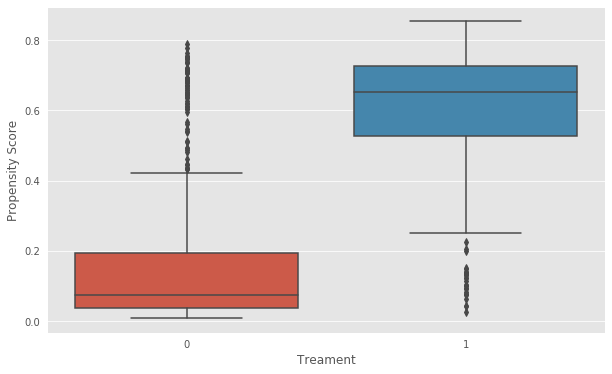

In [25]:
boxplot_df = pd.DataFrame({'pscore': pscore, 'treat': targets.squeeze()})

# plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='treat', y='pscore', data=boxplot_df);
plt.ylabel('Propensity Score');
plt.xlabel('Treament');

Looking at the plot below, we can see that our features,  X , does in fact contain information about the user receiving treatment. The distributional difference between the propensity scores for the two group justifies the need for matching, since they are not directly comparable otherwise.

Although, there's a distributional difference in the density plot, but in this case, what we see is that there's overlap everywhere, so this is actually the kind of plot we would like to see if we're going to do propensity score matching. What we mean by overlap is that no matter where we look on the plot, even though there might be more control than treatment or vice versa, there will still be some subject from either group. The notion of overlap means that our positivity assumption is probably reasonable. Remember positivity refers to the situation where all of the subjects in the study have at least some chance of receiving either treatment. And that appears to be the case here, hence this would be a situation where we would feel comfortable to proceed with our propensity score matching.

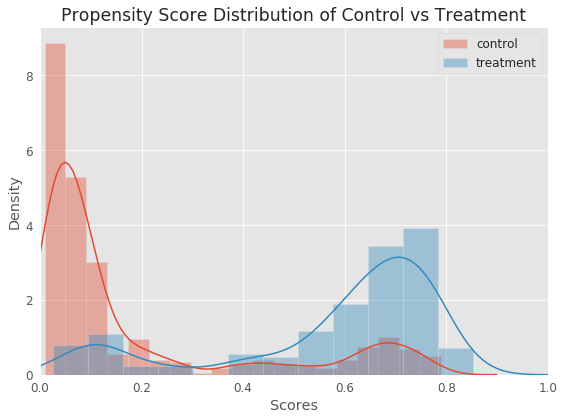

In [26]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

### 6. Matching Estimator

Matching is a method that attempts to control for confounding and make an observational study more like a randomized trial. The main idea is to match individuals in the treated group  $A=1 $ to similar individuals in the control group  $A=0$  on the covariates  $X$ . This is similar to the notion of estimating the causal effect of the treatment on the treated.

e.g. Say there is only 1 covariate that we care about, *age*. Then, in a randomized trial, for any particular age, there should be about the same number of treated and untreated people. In the cases where older people are more likely to get  $A=1 $, if we were to match treated people to control people of the same age, there will be about the same number of treated and controls at any age.

Once the data are matched, we can treat it as if it was a randomized trial. The advantage of this approach is that it can help reveal lack of overlap in covariate distribution.

Caveat is that we can't exactly match on the full set of covariates, so what we'll do is try and make sure the distribution of covariates is balanced between the groups, also referred to as stochastic balance (The distribution of confounders being similar for treated and untreated subjects).

#### Question 6

**Task -** Match treated and control subjects using neareast neighbor matching on the estimated propensity score.

#### Answer Q6

In [27]:
# Define params and inputs
mask = lalonde_df['treat'] == 1
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
agg_operations = {'treat': 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in covariates
})

In [28]:
from sklearn.neighbors import NearestNeighbors

# Helper function that uses K-NN algorithm to calculate 
# similarity distance and get the similarity indices for matching
def get_similar(pos_pscore, neg_pscore, topn=5, n_jobs=1):
    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))
    
    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]

    return sim_distances, sim_indices

In [29]:
sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)

In [30]:
# Display matching table
df_pos = lalonde_df[mask]
df_neg = lalonde_df[~mask].iloc[sim_indices[:, 0]]
df_matched = (df_pos.reset_index(drop=True)
              .merge(df_neg.reset_index(drop=True), 
                     left_index=True, 
                     right_index=True))

num_matched_pairs = df_neg.shape[0]

print('Number of matched pairs: ', num_matched_pairs)
df_matched

Number of matched pairs:  185


,treat_x,age_x,educ_x,black_x,hispan_x,married_x,nodegree_x,re74_x,re75_x,re78_x,treat_y,age_y,educ_y,black_y,hispan_y,married_y,nodegree_y,re74_y,re75_y,re78_y
0,1,37,11,1,0,1,1,0.00,0.00,9930.0460,0,55,4,1,0,0,1,0.0000,0.0000,0.00000
1,1,22,9,0,1,0,1,0.00,0.00,3595.8940,0,26,8,0,1,0,1,3168.1340,5872.2580,11136.15000
2,1,30,12,1,0,0,0,0.00,0.00,24909.4500,0,26,12,1,0,0,0,0.0000,1448.3710,0.00000
3,1,27,11,1,0,0,1,0.00,0.00,7506.1460,0,18,11,1,0,0,1,0.0000,1367.8060,33.98771
4,1,33,8,1,0,0,1,0.00,0.00,289.7899,0,19,11,1,0,0,1,5607.4220,3054.2900,94.57450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,1,33,12,1,0,1,0,20279.95,10941.35,15952.6000,0,17,11,0,1,0,1,0.0000,873.6774,7759.54200
181,1,25,14,1,0,1,0,35040.07,11536.57,36646.9500,0,32,15,0,0,0,0,489.8167,968.5645,7684.17800
182,1,35,9,1,0,1,1,13602.43,13830.64,12803.9700,0,52,8,1,0,1,1,5454.5990,666.0000,0.00000
183,1,35,8,1,0,1,1,13732.07,17976.15,3786.6280,0,47,10,1,0,0,1,21918.3200,4323.6290,19438.02000


#### Question 7.

Assess covariate balance after matching.  For this, compute the absolute standardized differences in means in the covariates after matching (Rosenbaum and Rubin, 1985), $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$
where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspongdingly, the sample variances treatment and control groups before matching. 
(One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances.)
Comment on covariate balance.

**Answer -** Now, you notice that the formula for ASMD is exact replica of the one at the top when we calculate the ASMD before we do any matching. Now let's reuse the function `comput_table_one_smd()` we have from the above and see how matching can improve our dataset from imbalanced.

In [31]:
# Create matching table
df_pos = lalonde_df[mask]
df_neg = lalonde_df[~mask].iloc[sim_indices[:, 0]]
df_matched = pd.concat([df_pos, df_neg], axis=0) # this time we join by axis-0

# Calculate Rosenbaum ASMD
table_one_matched = df_matched.groupby('treat').agg(agg_operations)
table_one_smd_matched = compute_table_one_smd(table_one_matched, covariates)

table_one_smd_matched

,covariates,smd
0,age,0.0234
1,educ,0.0965
2,black,0.0147
3,hispan,0.0438
4,married,0.1157
5,nodegree,0.1098
6,re74,0.0700
7,re75,0.0576


### Question 8.

Estimate the average effect of treatment on the treated after matching.  Is this a good estimate?

In [32]:
# pair t-test
ttest = scipy.stats.ttest_rel(df_pos['re78'].values, df_neg['re78'].values)

print("The statistic of t-test:", ttest.statistic)
print("The p-value of t-test:", ttest.pvalue)

The statistic of t-test: 1.832064848129813
The p-value of t-test: 0.06855839639919913


This result tells us after using matching adjustment to ensure comparability between the treatment and control group, we find that receiving.